## Basic Reading of Sentinel-2 images, plots, and statistics

This beginner Notebook shows how to load and read Sentinel-2 TOC reflectance data and how to make simple plots. First, we will open sample Sentinel-2 image files using the rasterio package, plot some TOC reflectance image bands and perform basic statistics using matplotlib.pyplot and seaborn.

So let's start with importing the required packages.

In [1]:
import rasterio
import matplotlib.pyplot as mplot                       #standard matplotlib module
from mpl_toolkits.axes_grid1 import make_axes_locatable #this module is needed to resize the colorbar to the plot size
import seaborn as sns                                   #seaborn gives nicer plotting results
import glob                                             #module to search for dirs/files
import numpy as np                                      #standard module for calculations, statistics, etc.
import sys 

In the next step, we load Sentinel-2 V200 10 m TOC reflectance files for the 0.665 $\mu$m (RED) and 0.842 $\mu$m (NIR) bands.

In [2]:
#filename of the Sentinel-2 image we will work on, B04=RED, B08=NIR
f_red = '/data/MTDA/TERRASCOPE_Sentinel2/TOC_V2/2017/05/26/S2A_20170526T105031_31UES_TOC_V200/S2A_20170526T105031_31UES_TOC-B04_10M_V200.tif'
f_nir = '/data/MTDA/TERRASCOPE_Sentinel2/TOC_V2/2017/05/26/S2A_20170526T105031_31UES_TOC_V200/S2A_20170526T105031_31UES_TOC-B08_10M_V200.tif'

#read the files with rasterio and print some attributes
with rasterio.open(f_red, 'r') as data:
    d_red = data.read(1).astype(float)
      
with rasterio.open(f_nir, 'r') as data:
    d_nir = data.read(1).astype(float)

After reading the data, we will first mask out all NoData values, as well as negative TOC reflectances, which are physically impossible. After this screening is done, we can compute the TOC NDVI. 

In [3]:
#discard negative TOC reflectances and 32767 --> NoData
noval = np.where((d_red == 32767) | (d_red < 0) | (d_nir == 32767) | (d_nir < 0))    
d_red[noval] = np.nan
d_nir[noval] = np.nan

#apply the scaling factor
d_red = d_red * 0.0001
d_nir = d_nir * 0.0001

#compute the NDVI from RED and NIR
d_ndvi = (d_nir - d_red) / (d_nir + d_red)

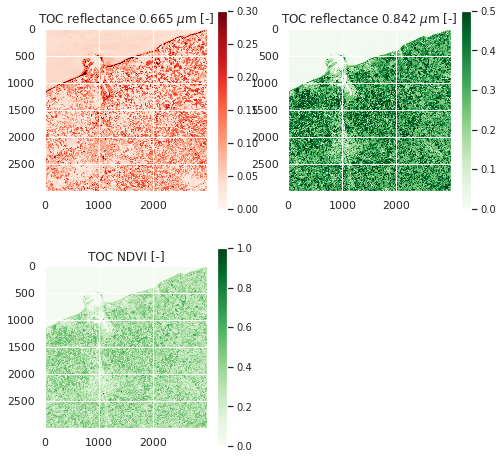

In [4]:
#set the seaborn plotting environment
sns.set()

#take a subset, in this case the upper left quadrant
sub = np.array([500, 3500])

#map plots for the RED and NIR and resulting NDVI, use subplots
mplot.figure(figsize=(8, 8))
mplot.subplot(221)

#TOC reflectances
mplot.imshow(d_red[sub[0]:sub[1],sub[0]:sub[1]], cmap='Reds', vmin=0., vmax=0.3)
mplot.title('TOC reflectance 0.665 $\mu$m [-]')

cb = mplot.colorbar(aspect=20)  
cb.ax.tick_params(labelsize=10)

mplot.subplot(222)
mplot.imshow(d_nir[sub[0]:sub[1],sub[0]:sub[1]], cmap='Greens', vmin=0., vmax=0.5)
mplot.title('TOC reflectance 0.842 $\mu$m [-]')
cb = mplot.colorbar(aspect=20)  
cb.ax.tick_params(labelsize=10)

#TOC NDVI
mplot.subplot(223)
mplot.imshow(d_nir[sub[0]:sub[1],sub[0]:sub[1]], cmap='Greens', vmin=0, vmax=1.0)
mplot.title('TOC NDVI [-]')

#same as for the TOC reflectance colorbar, but now for TOC NDVI
cb = mplot.colorbar(aspect=20)  
cb.ax.tick_params(labelsize=10)

Next, we will show you how to present the RED, NIR, and NDVI histograms in a convenient way. The seaborn package contains a wealth of plotting functions that improve on the plot esthetics.
The histograms of RED, NIR, and the resulting NDVI are plotted.

Text(0, 0.5, 'frequency [%]')

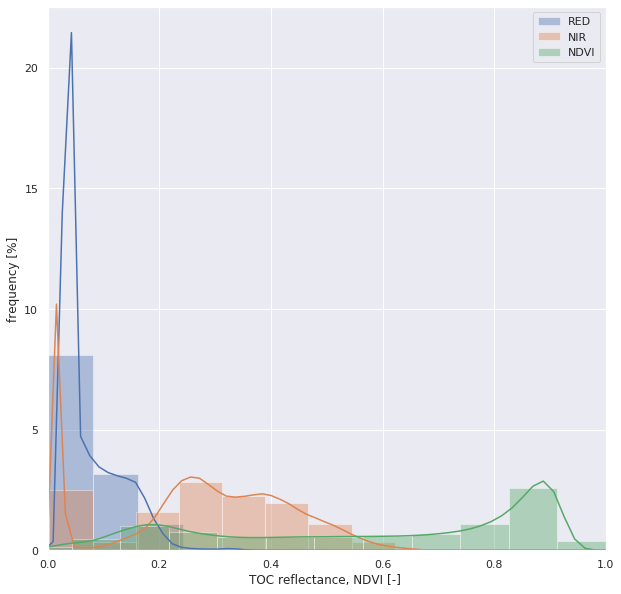

In [5]:
#get the valid observations from RED and NIR
d_red_sub  = d_red[sub[0]:sub[1],sub[0]:sub[1]]
d_nir_sub  = d_nir[sub[0]:sub[1],sub[0]:sub[1]]
d_ndvi_sub = d_ndvi[sub[0]:sub[1],sub[0]:sub[1]]

#only consider data valid for RED, NIR, and NDVI
val = np.where((np.isfinite(d_red_sub)) & (np.isfinite(d_nir_sub)) & (np.isfinite(d_ndvi_sub)))

mplot.figure(figsize=(10, 10))
sns.distplot(d_red_sub[val], bins=20, label='RED')
sns.distplot(d_nir_sub[val], bins=20, label='NIR')
sns.distplot(d_ndvi_sub[val], bins=20, label='NDVI')
mplot.legend(loc='best')
mplot.xlabel('TOC reflectance, NDVI [-] ')
mplot.xlim(0,1)
mplot.ylabel('frequency [%]')